In [88]:
# Interactive shell
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Data wrangling and standard library
import copy

import matplotlib.pyplot as plt
import numpy as np

# Machine learning
from keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.nn import softmax

In [4]:
# Keras gets its randomness from numpy rng
from numpy.random import seed

seed(1227)
# Set the global random seed
from tensorflow.random import set_seed

set_seed(1227)

## Helper Functions

In [68]:
def eval_plots(history):
    """Plot the loss and accuracy of the model"""
    # Plot the loss
    plt.figure(figsize=(8, 5))
    plt.plot(history.history["loss"], "bo", label="Training Loss")
    plt.plot(history.history["val_loss"], "b", label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot the accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(history.history["accuracy"], "bo", label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], "b", label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim(ymin=0, ymax=1)
    plt.legend()
    plt.show()

## Load Training Data

In [4]:
with open("data/processed_data.npy", "rb") as f:
    train_X = np.load(f, allow_pickle=True)
    train_y = np.load(f, allow_pickle=True)
    test_X = np.load(f, allow_pickle=True)
    test_y = np.load(f, allow_pickle=True)

In [9]:
train_X.shape, train_y.shape

((8982, 10000), (8982, 46))

In [10]:
test_X.shape, test_y.shape

((2246, 10000), (2246, 46))

In [11]:
train_X, train_y

(array([[0., 1., 1., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]], dtype=float32))

In [12]:
test_X, test_y

(array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

## Network Architecture

### Layers

In a stack of Dense layers, each layer can only access information present in the output of the previous layer. If one layer drops some information relevant to the classification problem, then this information can never be recovered by later layers; in other words, each layer can potentially become an information bottleneck. For this reason, we will use two 64-dimensional 'reLu' hidden layers to learn to separate 46 different classes. 

In [18]:
baseline_model = Sequential(
    [
        Input(shape=(10000,)),  # Expected shape of the input
        Dense(units=64, activation="relu", name="layer1"),
        Dense(units=64, activation="relu", name="layer2"),
        Dense(
            units=46, activation="linear", name="output_layer"
        ),  # Use linear activation for numerical stability
    ],
    name="newswire_baseline_model",
)

In [19]:
baseline_model.summary()

Model: "newswire_baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 64)                640064    
                                                                 
 layer2 (Dense)              (None, 64)                4160      
                                                                 
 output_layer (Dense)        (None, 46)                2990      
                                                                 
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
_________________________________________________________________


In [23]:
L1_num_params = (
    (10000 * 64) + 64
)  # W1 parameters (64 units times 10000 input features)  + b1 parameters (64 neurons or units)
L2_num_params = (
    (64 * 64) + 64
)  # W2 parameters (64 units times 1 activation vector a1 outputted by layer 1) + b2 parameters (64 neuron or units)
output_num_params = (
    (64 * 46) + 46
)  # W3 parameters (46 units times 1 activation vector a2 outputted by layer 2) + b3 parameters (46 neurons or units)
print(
    "L1 params = ",
    L1_num_params,
    ", L2 params = ",
    L2_num_params,
    ", output params = ",
    output_num_params,
)

L1 params =  640064 , L2 params =  4160 , output params =  2990


* For each input training example (a row of the data matrix `train_X`), the multilayer perceptron would output a 46-dimensional vector, of which each element represents a topic class from 0 to 45.

* Because we used the linear activation function as the output layer, the outputs would not be probabilities, but logit values that range from large negative numbers to large positive numbers. The output must be sent through a softmax function when performing a prediction that expects a probability.  


In [29]:
[layer1, layer2, layer3] = baseline_model.layers
# Example the shapes of the parameters
W1, b1 = layer1.get_weights()
W2, b2 = layer2.get_weights()
W3, b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (10000, 64), b1 shape = (64,)
W2 shape = (64, 64), b2 shape = (64,)
W3 shape = (64, 46), b3 shape = (46,)


### Loss Function & Optimizer

Because we used one-hot encoding (a matrix) rather than integer tensor (a tensor) for processing the labels, we need to use `categorical_crossentropy` rather than `sparse_categorical_entropy`.

In addition, we will use the 'Adam' optimizers:

In [28]:
baseline_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(
        from_logits=True
    ),  # Use from_logits=True for numerical stability
    metrics=["accuracy"],
)

## Validation Set

We set apart 1,000 samples in the training data to use as validation set:

In [30]:
validate_X = train_X[:1000]
partial_train_X = train_X[1000:]

validate_y = train_y[:1000]
partial_train_y = train_y[1000:]

In [31]:
validate_X.shape, partial_train_X.shape

((1000, 10000), (7982, 10000))

In [32]:
validate_y.shape, partial_train_y.shape

((1000, 46), (7982, 46))

## Training Baseline Model

For the baseline model, we wish to find a model that has some statistical power, even if it overfits, so we can prune it later. We will use a batch_size of 512 instead of 32, which is the Tensorflow default; in other words, it takes roughly $(7982 / 512)\approx16$ iterations to complete one epoch, which is one single pass through of the entire training data. Finally, we will pass the entire training data through the network 25 times.  

In [35]:
baseline_history = baseline_model.fit(
    partial_train_X,
    partial_train_y,
    epochs=25,
    batch_size=512,
    validation_data=(validate_X, validate_y),
)

Epoch 1/25
16/16 [==============================] - 1s 30ms/step - loss: 0.0663 - accuracy: 0.9625 - val_loss: 1.0999 - val_accuracy: 0.8100
Epoch 2/25
16/16 [==============================] - 0s 17ms/step - loss: 0.0670 - accuracy: 0.9634 - val_loss: 1.1088 - val_accuracy: 0.8050
Epoch 3/25
16/16 [==============================] - 0s 16ms/step - loss: 0.0640 - accuracy: 0.9664 - val_loss: 1.1423 - val_accuracy: 0.8070
Epoch 4/25
16/16 [==============================] - 0s 16ms/step - loss: 0.0654 - accuracy: 0.9642 - val_loss: 1.1147 - val_accuracy: 0.8040
Epoch 5/25
16/16 [==============================] - 0s 16ms/step - loss: 0.0659 - accuracy: 0.9662 - val_loss: 1.1341 - val_accuracy: 0.8030
Epoch 6/25
16/16 [==============================] - 0s 21ms/step - loss: 0.0659 - accuracy: 0.9645 - val_loss: 1.1321 - val_accuracy: 0.7990
Epoch 7/25
16/16 [==============================] - 0s 20ms/step - loss: 0.0662 - accuracy: 0.9638 - val_loss: 1.0995 - val_accuracy: 0.8090
Epoch 8/25
16

### Saving Baseline Model Weights

We can manually save the weights as follows:

In [36]:
baseline_model.save_weights("model_output/baseline_model_weights.h5")

The weights can be restored by creating a new sequential model and calling the `load_weights` method on the model instance:

In [45]:
temp_model = Sequential(
    [
        Input(shape=(10000,)),  # Expected shape of the input
        Dense(units=64, activation="relu", name="layer1"),
        Dense(units=64, activation="relu", name="layer2"),
        Dense(
            units=46, activation="linear", name="output_layer"
        ),  # Use linear activation for numerical stability
    ],
    name="temp_model",
)
temp_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(
        from_logits=True
    ),  # Use from_logits=True for numerical stability
    metrics=["accuracy"],
)

Initially, the weights of the new model instance are randomly initialized and are not equal to the trained model:

In [51]:
for temp_weight, baseline_weight in zip(
    temp_model.get_weights(), baseline_model.get_weights()
):
    print(np.allclose(temp_weight, baseline_weight))

False
False
False
False
False
False


After restoring the weights, the weights should be the same:

In [52]:
temp_model.load_weights("model_output/baseline_model_weights.h5")
for temp_weight, baseline_weight in zip(
    temp_model.get_weights(), baseline_model.get_weights()
):
    print(np.allclose(temp_weight, baseline_weight))

True
True
True
True
True
True


In [53]:
del temp_model

### Saving Baseline Model

In [55]:
baseline_model.save("model_output/baseline_model.h5")

## Plot Training & Validation Loss

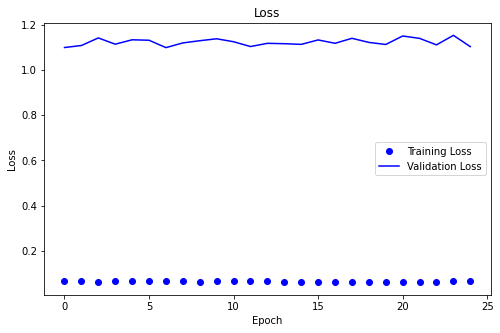

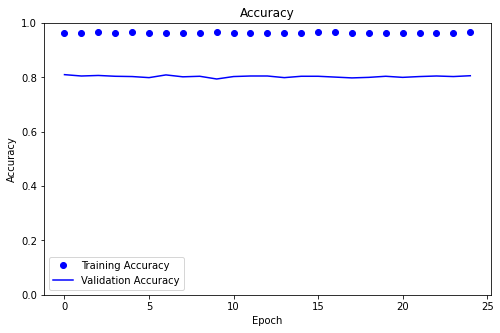

In [69]:
eval_plots(baseline_history)

* Using the Adam optimizer leads to ~$80\%$ validation accuracy starting from just 1 epoch and does not improve over more epochs. 

* Similarly, both training and validation losses do not decrease over more epochs and stay consistently flat.

## Evaluation

In [70]:
results = baseline_model.evaluate(x=test_X, y=test_y)
# Returns the loss value & metrics values
results

71/71 [==============================] - 0s 2ms/step - loss: 1.2600 - accuracy: 0.7939


[1.2599513530731201, 0.7938557267189026]

For multiclass classification problems, the baseline accuracy to beat is the purely random classifier.

In [77]:
# Make a shallow copy of the test labels
test_y_copy = copy.copy(test_y)
# Randomly shuffle the test labels, so this new order will serve as randomly predicted labels for the test data
np.random.shuffle(test_y_copy)
# Calculate the accuracy of a random classifier on the test data
hits_array = np.array(test_y) == np.array(test_y_copy)
float(np.sum(hits_array)) / len(test_y)

44.39626001780944

Just by random guesses, we get about $44\%$ accuracy on the test set; the $79.39\%$ accuracy comfortably beats this baseline classifier.

## Predictions

The predictions can be obtained as follows:

In [78]:
predictions = baseline_model.predict(x=test_X)
predictions.shape

71/71 [==============================] - 0s 2ms/step


(2246, 46)

Each row of the 2246 by 46 matrix contains a vector of logits; each of the 46 elements of the vector of logits represent the value for each topic class:  

In [80]:
predictions[0], predictions[2]

(array([ 7.678684  , -2.2660732 , -1.8776331 , -2.3332567 , -1.9095824 ,
        -0.30281326, -0.16676554, -0.49531505, -0.3080081 , -1.038972  ,
         2.0388968 , -6.1818933 , -5.32623   , -2.6588871 , -4.0528436 ,
        -2.1009994 , -4.184793  , -1.945438  , -1.2769958 ,  0.23134932,
        -1.1961191 , -7.276192  , -0.5317315 , -3.2842295 , -0.48287928,
        -3.556288  , -0.2768845 , -1.0415691 , -1.0893279 , -0.80837846,
        -5.820365  , -8.484936  ,  1.253658  , -0.59512395, -2.8274288 ,
        -3.558198  , -1.688417  , -5.1534333 , -3.3189192 , -5.668709  ,
        -3.1704473 , -3.9280987 , -2.298363  , -7.2508254 , -2.6753616 ,
        -2.838736  ], dtype=float32),
 array([-3.0301769 , -2.6048262 , -4.6987348 ,  7.1878033 ,  2.1245205 ,
        -6.4938645 , -4.3946104 , -3.5894535 ,  0.02900334, -0.8816834 ,
        -2.4548125 ,  1.5040354 , -2.0291011 , -1.5224433 , -3.4866014 ,
        -2.8003786 ,  0.09166485, -5.668612  , -4.5441294 ,  2.3932142 ,
        -0.04

In [84]:
np.max(predictions[2])

7.1878033

If we simply wish to obtain the vector of predicted class integers:

In [87]:
# Find max values across the 46 columns in each row
predicted_topics = predictions.argmax(axis=1)
# This is a 1D array of length 2246 predictions
predicted_topics.shape
predicted_topics

(2246,)

array([0, 3, 3, ..., 3, 3, 1])

However, if we wish to obtain a matrix of vector of probabilities:

In [91]:
predicted_probs = softmax(logits=predictions)
predicted_probs.shape

TensorShape([2246, 46])

In [94]:
predicted_probs[0], predicted_probs[2]

(<tf.Tensor: shape=(46,), dtype=float32, numpy=
 array([9.9014622e-01, 4.7505739e-05, 7.0055699e-05, 4.4418986e-05,
        6.7852860e-05, 3.3836006e-04, 3.8767137e-04, 2.7911086e-04,
        3.3660681e-04, 1.6205759e-04, 3.5186063e-03, 9.4651381e-07,
        2.2270851e-06, 3.2073713e-05, 7.9572274e-06, 5.6032051e-05,
        6.9735906e-06, 6.5463020e-05, 1.2773120e-04, 5.7724869e-04,
        1.3849087e-04, 3.1686864e-07, 2.6912935e-04, 1.7161945e-05,
        2.8260329e-04, 1.3074136e-05, 3.4724799e-04, 1.6163730e-04,
        1.5409909e-04, 2.0408681e-04, 1.3587413e-06, 9.4608104e-08,
        1.6045233e-03, 2.5259805e-04, 2.7098948e-05, 1.3049186e-05,
        8.4648404e-05, 2.6471691e-06, 1.6576807e-05, 1.5812489e-06,
        1.9230092e-05, 9.0144158e-06, 4.5996301e-05, 3.2500907e-07,
        3.1549636e-05, 2.6794271e-05], dtype=float32)>,
 <tf.Tensor: shape=(46,), dtype=float32, numpy=
 array([3.5706165e-05, 5.4634991e-05, 6.7312862e-06, 9.7803795e-01,
        6.1858566e-03, 1.1181063

In [96]:
predicted_topics_prob = predicted_probs.numpy().argmax(axis=1)
predicted_topics_prob.shape
predicted_topics_prob

(2246,)

array([0, 3, 3, ..., 3, 3, 1])

The two methods lead to the same vector of predicted topic labels:

In [98]:
np.equal(predicted_topics, predicted_topics_prob).all()

True

## Model Using Root Mean Squared Propagation 

Finally, we train another neural network using another optimizer:

In [100]:
rmsprop_model = Sequential(
    [
        Input(shape=(10000,)),  # Expected shape of the input
        Dense(units=64, activation="relu", name="layer1"),
        Dense(units=64, activation="relu", name="layer2"),
        Dense(
            units=46, activation="linear", name="output_layer"
        ),  # Use linear activation for numerical stability
    ],
    name="newswire_rmsprop_model",
)
rmsprop_model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss=CategoricalCrossentropy(
        from_logits=True
    ),  # Use from_logits=True for numerical stability
    metrics=["accuracy"],
)
rmsprop_history = rmsprop_model.fit(
    partial_train_X,
    partial_train_y,
    epochs=25,
    batch_size=512,
    validation_data=(validate_X, validate_y),
)

Epoch 1/25
16/16 [==============================] - 1s 36ms/step - loss: 2.7412 - accuracy: 0.5000 - val_loss: 1.8263 - val_accuracy: 0.6250
Epoch 2/25
16/16 [==============================] - 0s 17ms/step - loss: 1.5709 - accuracy: 0.6700 - val_loss: 1.4168 - val_accuracy: 0.7150
Epoch 3/25
16/16 [==============================] - 0s 16ms/step - loss: 1.2143 - accuracy: 0.7415 - val_loss: 1.2229 - val_accuracy: 0.7350
Epoch 4/25
16/16 [==============================] - 0s 17ms/step - loss: 0.9947 - accuracy: 0.7868 - val_loss: 1.1412 - val_accuracy: 0.7460
Epoch 5/25
16/16 [==============================] - 0s 16ms/step - loss: 0.8243 - accuracy: 0.8239 - val_loss: 1.0464 - val_accuracy: 0.7800
Epoch 6/25
16/16 [==============================] - 0s 16ms/step - loss: 0.6917 - accuracy: 0.8500 - val_loss: 0.9872 - val_accuracy: 0.7850
Epoch 7/25
16/16 [==============================] - 0s 17ms/step - loss: 0.5741 - accuracy: 0.8755 - val_loss: 0.9295 - val_accuracy: 0.7840
Epoch 8/25
16

In [101]:
# Save model
rmsprop_model.save("model_output/rmsprop_model.h5")

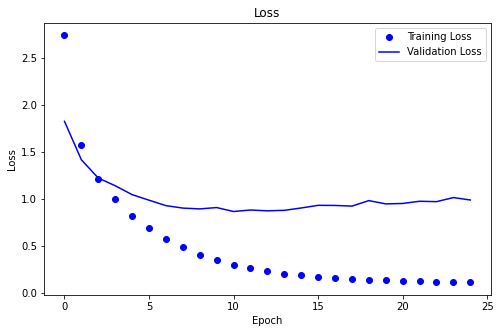

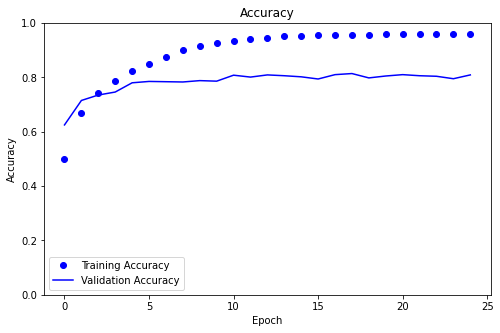

In [102]:
# Evaluation plot
eval_plots(rmsprop_history)

In [103]:
rmsprop_model.evaluate(x=test_X, y=test_y)

71/71 [==============================] - 0s 2ms/step - loss: 1.0394 - accuracy: 0.8032


[1.0393762588500977, 0.8032057285308838]

Around 5 to 10 epochs, the network begins to overfit as validation accuracy and loss begin to degrade and diverge with training performance.

In [104]:
del rmsprop_model

In [106]:
# Retrain the model with 9 epochs
retrained_rmsprop_model = Sequential(
    [
        Input(shape=(10000,)),  # Expected shape of the input
        Dense(units=64, activation="relu", name="layer1"),
        Dense(units=64, activation="relu", name="layer2"),
        Dense(
            units=46, activation="linear", name="output_layer"
        ),  # Use linear activation for numerical stability
    ],
    name="newswire_rmsprop_model",
)
retrained_rmsprop_model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss=CategoricalCrossentropy(
        from_logits=True
    ),  # Use from_logits=True for numerical stability
    metrics=["accuracy"],
)
retrained_rmsprop_model.fit(
    partial_train_X,
    partial_train_y,
    epochs=9,
    batch_size=512,
    validation_data=(validate_X, validate_y),
)

Epoch 1/9
16/16 [==============================] - 1s 33ms/step - loss: 2.7018 - accuracy: 0.5048 - val_loss: 1.8157 - val_accuracy: 0.6430
Epoch 2/9
16/16 [==============================] - 0s 20ms/step - loss: 1.5468 - accuracy: 0.6735 - val_loss: 1.3745 - val_accuracy: 0.7040
Epoch 3/9
16/16 [==============================] - 0s 16ms/step - loss: 1.1805 - accuracy: 0.7435 - val_loss: 1.1950 - val_accuracy: 0.7320
Epoch 4/9
16/16 [==============================] - 0s 20ms/step - loss: 0.9492 - accuracy: 0.7952 - val_loss: 1.0643 - val_accuracy: 0.7530
Epoch 5/9
16/16 [==============================] - 0s 17ms/step - loss: 0.7764 - accuracy: 0.8336 - val_loss: 0.9875 - val_accuracy: 0.7740
Epoch 6/9
16/16 [==============================] - 0s 16ms/step - loss: 0.6377 - accuracy: 0.8663 - val_loss: 0.9495 - val_accuracy: 0.7810
Epoch 7/9
16/16 [==============================] - 0s 17ms/step - loss: 0.5300 - accuracy: 0.8874 - val_loss: 0.9232 - val_accuracy: 0.7920
Epoch 8/9
16/16 [===

In [107]:
# Evaluate the model
retrained_rmsprop_model.evaluate(x=test_X, y=test_y)

71/71 [==============================] - 0s 2ms/step - loss: 0.8913 - accuracy: 0.8037


[0.8912642598152161, 0.8036509156227112]

This is indeed the best result out of all three model:

In [108]:
retrained_rmsprop_model.save("model_output/best_rmsprop_model.h5")